<a href="https://colab.research.google.com/github/Diana9908/TP547/blob/main/Trabalho%20Final%201/Trabalho_Final_Parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

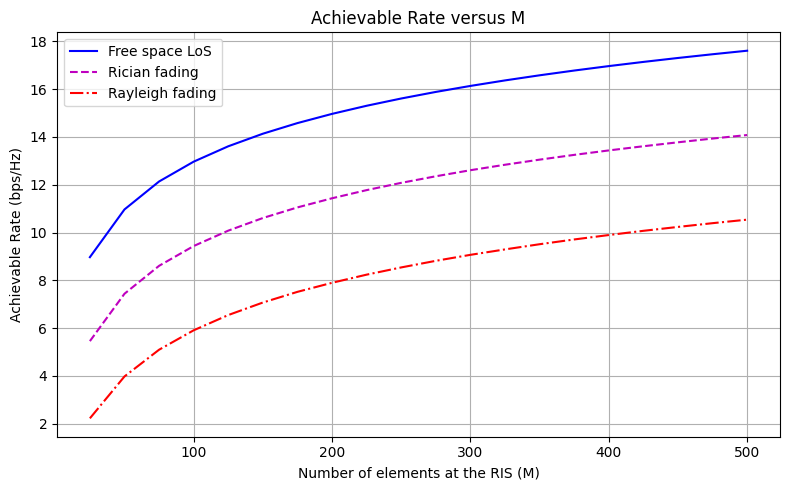

In [ ]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

N = 10000                                # Simulações de Monte Carlo
K_Rician = 3                             # Fator Rician
c0 = 10**(-30/10)                        # Fator de perda de percurso constante
Pt = 50*(10)**(-3)                       # Potência de transmissão Pt = 50 mW
sigma_cuad = 10**(-90/10)*(10**(-3))     # Variância de ruído -90 dBm
M = np.arange(25,500.1,25).astype(int)   # Número de elementos no RIS

R_U_sm_Rician = np.zeros(N)
R_U_sm_LOS = np.zeros(N)
R_U_sm_Ray = np.zeros(N)
R_U_meia_M_Rician = np.zeros(len(M))
R_U_meia_M_LOS = np.zeros(len(M))
R_U_meia_M_Ray = np.zeros(len(M))

# Localização BS
x_BS = 0
y_BS = 0

# Localização RIS
x_RIS = 50
y_RIS = 0

# Localização UE
x_U = 50
y_U = 5

# Distância entre BS e RIS
d_BS_RIS = math.sqrt((x_BS - x_RIS)**2 + (y_BS - y_RIS)**2)

# Distância entre BS e UE
d_RIS_U = math.sqrt((x_U - x_RIS)**2 + (y_U - y_RIS)**2)

# Perda de percurso
def PL(c0,d,alpha):
  path_loss = c0*(d)**(-alpha)
  return path_loss

PL_BS_RIS_Rician = PL(c0,d_BS_RIS,2.4)
PL_RIS_U_Rician = PL(c0,d_RIS_U,2.4)
PL_BS_RIS_LOS = PL(c0,d_BS_RIS,2)
PL_RIS_U_LOS = PL(c0,d_RIS_U,2)
PL_BS_RIS_Ray = PL(c0,d_BS_RIS,2.8)
PL_RIS_U_Ray = PL(c0,d_RIS_U,2.8)

# Função para gerar M amostras de uma distribuição normal padrão a partir
# de uma distribuição exponencial
# Metodo da Aceitacao-Rejeicao

def Normal(a, quant_amostras):

  a = a
  quant_amostras = quant_amostras
  while len(a) < quant_amostras:

    # Gerar uma amostra Y da distribuição proposta g(x) = e^(-x), x ≥ 0
    # Método da transformada inversa
    y_exp = -np.log(np.random.uniform(0,1))

    # Gerar um número aleatório U2 ~ Uniforme(0,1), independente de Y
    u2 = np.random.uniform(0,1)

    # Critério de aceitação do método de aceitação-rejeição
    if u2 <= np.exp((-(y_exp-1)**2)/2):
      Z_abs = y_exp

    # Tornar a amostra simétrica. Usamos U3 ~ Uniforme(0,1) para decidir se
    # refletimos o valor para o lado negativo
      u3 = np.random.uniform(0,1)
      if u3 <= 0.5:
        Z = Z_abs
      else:
        Z = - Z_abs
      a.append(Z)
  return a


for m in range(len(M)):

  Theta_Rician = np.zeros(M[m])
  Theta_LOS = np.zeros(M[m])
  Theta_Ray = np.zeros(M[m])

  for n in range(N):

    # Componente LOS

    h_LOS_BS_RIS = np.exp(-1j * 2 * np.pi * np.random.rand(M[m]))
    h_LOS_RIS_U = np.exp(-1j * 2 * np.pi * np.random.rand(M[m]))

    # Componente nLOS

    a = Normal(list(), M[m])
    b = Normal(list(), M[m])
    c = Normal(list(), M[m])
    d = Normal(list(), M[m])

    h_nLOS_BS_RIS = math.sqrt(1/2)* (np.array([a]) + 1j*np.array([b]))
    h_nLOS_RIS_U = math.sqrt(1/2)* (np.array([c]) + 1j*np.array([d]))

    # Canais entre BS e RIS, para espaço livre LOS, desvanecimento Rician e desvanecimento Rayleigh

    h_BS_RIS_Rician = (np.sqrt(PL_BS_RIS_Rician))*(math.sqrt(K_Rician/(1+K_Rician))*h_LOS_BS_RIS + math.sqrt(1/(1+K_Rician))*h_nLOS_BS_RIS)
    h_BS_RIS_Rician = h_BS_RIS_Rician.reshape((1,M[m]))

    h_BS_RIS_LOS = (np.sqrt(PL_BS_RIS_LOS))* h_LOS_BS_RIS
    h_BS_RIS_LOS = h_BS_RIS_LOS.reshape((1,M[m]))

    h_BS_RIS_Ray = (np.sqrt(PL_BS_RIS_Ray))* h_nLOS_BS_RIS
    h_BS_RIS_Ray = h_BS_RIS_Ray.reshape((1,M[m]))

    # Canais entre RIS e UE, para espaço livre LOS, desvanecimento Rician e desvanecimento Rayleigh

    h_RIS_U_Rician = (np.sqrt(PL_RIS_U_Rician))*(math.sqrt(K_Rician/(1+K_Rician))*h_LOS_RIS_U + math.sqrt(1/(1+K_Rician))*h_nLOS_RIS_U)
    h_RIS_U_Rician = h_RIS_U_Rician.reshape((M[m],1))

    h_RIS_U_LOS = (np.sqrt(PL_RIS_U_LOS))* h_LOS_RIS_U
    h_RIS_U_LOS = h_RIS_U_LOS.reshape((M[m],1))

    h_RIS_U_Ray = (np.sqrt(PL_RIS_U_Ray))* h_nLOS_RIS_U
    h_RIS_U_Ray = h_RIS_U_Ray.reshape((M[m],1))

    # RIS

    for mi in range(M[m]):
      Theta_Rician[mi] = - cmath.phase(h_BS_RIS_Rician[0,mi]) - cmath.phase(h_RIS_U_Rician[mi,0])
      Theta_LOS[mi] = - cmath.phase(h_BS_RIS_LOS[0,mi]) - cmath.phase(h_RIS_U_LOS[mi,0])
      Theta_Ray[mi] = - cmath.phase(h_BS_RIS_Ray[0,mi]) - cmath.phase(h_RIS_U_Ray[mi,0])

    RIS_Rician = np.diag(np.exp(1j*Theta_Rician))
    RIS_LOS = np.diag(np.exp(1j*Theta_LOS))
    RIS_Ray = np.diag(np.exp(1j*Theta_Ray))

    # Canais compostos

    h_U_Rician = h_BS_RIS_Rician @ RIS_Rician @ h_RIS_U_Rician
    h_U_LOS = h_BS_RIS_LOS @ RIS_LOS @ h_RIS_U_LOS
    h_U_Ray = h_BS_RIS_Ray @ RIS_Ray @ h_RIS_U_Ray

    # Ganho

    G_U_Rician = abs((h_U_Rician)**2)
    G_U_LOS = abs((h_U_LOS)**2)
    G_U_Ray = abs((h_U_Ray)**2)

    # Taxa de dados atingível

    R_U_Rician = np.log2(1 + (Pt*G_U_Rician)/(sigma_cuad))
    R_U_LOS = np.log2(1 + (Pt*G_U_LOS)/(sigma_cuad))
    R_U_Ray = np.log2(1 + (Pt*G_U_Ray)/(sigma_cuad))

    R_U_sm_Rician[n] = R_U_Rician.item()
    R_U_sm_LOS[n] = R_U_LOS.item()
    R_U_sm_Ray[n] = R_U_Ray.item()

  # Taxa média de dados

  R_U_meia_Rician = np.mean(R_U_sm_Rician)
  R_U_meia_LOS = np.mean(R_U_sm_LOS)
  R_U_meia_Ray = np.mean(R_U_sm_Ray)

  R_U_meia_M_Rician[m] = R_U_meia_Rician
  R_U_meia_M_LOS[m] = R_U_meia_LOS
  R_U_meia_M_Ray[m] = R_U_meia_Ray


plt.figure(figsize=(8, 5))
plt.plot(M, R_U_meia_M_LOS, 'b-', label='Free space LoS')
plt.plot(M, R_U_meia_M_Rician, 'm--', label='Rician fading')
plt.plot(M, R_U_meia_M_Ray, 'r-.', label='Rayleigh fading')
plt.grid(True)
plt.xlabel("Number of elements at the RIS (M)")
plt.ylabel("Achievable Rate (bps/Hz)")
plt.title("Achievable Rate versus M")
plt.legend()
plt.tight_layout()
plt.show()
